# 1. Install and Import Dependencies

In [2]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

Looking in indexes: https://download.pytorch.org/whl/cu118


In [3]:
!pip install stable-baselines3[extra] protobuf==3.20.*

In [4]:
!pip install mss pyautogui

In [5]:
!pip install pytesseract
import pytesseract
pytesseract.pytesseract.tesseract_cmd = 'C:/Program Files/Tesseract-OCR/tesseract.exe'

In [6]:
!pip install gymnasium

In [7]:
!pip install pillow

In [104]:
# MSS for screen capture
import mss
# Sending commands
import pyautogui
# Opencv for frame processing
import cv2
# Transformational framework
import numpy as np
# OCR for game over extraction
import pytesseract
from PIL import Image
# Visualize captured frames
from matplotlib import pyplot as plt
#Bring in time for pauses
import time
# Environment components
from gymnasium import Env
from gymnasium.spaces import Box, Discrete


# 2. Build the Environment

## 2.1 Create Environment

In [192]:
class CookieRun(Env):
  #Setup the environment action and observation shapes
  def __init__(self):
    super().__init__()
    self.observation_space = Box(low=0, high=255, shape=(1,90,120), dtype=np.uint8)
    self.action_space = Discrete(3)

    self.cap = mss.mss()
    # game window
    self.game_location = {'top':0, 'left':0, 'width':1320, 'height':1080}
    # gameover window
    self.done_location = {'top':260, 'left':780, 'width':337, 'height':344}
    file = cv2.imread('./done.png')
    self.img = cv2.cvtColor(file, cv2.COLOR_BGR2HSV)
    self.img_hist = cv2.calcHist([self.img], [0,1], None, [180,256], [0,180,0, 256])
    cv2.normalize(self.img_hist, self.img_hist, 0, 1, cv2.NORM_MINMAX)
    # reset x window
    self.x_location = {'top':192, 'left':1393, 'width':84, 'height':88}
    file = cv2.imread('./close.png')
    self.x_img = cv2.cvtColor(file, cv2.COLOR_BGR2HSV)
    self.x_img_hist = cv2.calcHist([self.x_img], [0,1], None, [180,256], [0,180,0, 256])
    cv2.normalize(self.x_img_hist, self.x_img_hist, 0, 1, cv2.NORM_MINMAX)
    # score window
    self.score_location = {'top':160, 'left':760, 'width':350, 'height':64}
    # health window
    self.health_location = {'top' : 88, 'left':509, 'width':1188, 'height':10}
    #Sliding parameter
    self.sliding = False
    #Reward parameter
    self.pre_health = 1187
    self.pre_score = 0
    self.invincible_time = 0

  # What is called to do, something in the game
  def step(self, action):
    #Action key - 0 : Idle / 1 : jump / 2 : slide
    action_map = {
        0:'idle',
        1:'jump',
        2:'slide'
    }
    if action == 1:
        if not(self.sliding):
            pyautogui.click(x=206, y=869)
    if action == 2:
        if self.sliding:
            pyautogui.mouseDown(x=1625, y=889)
        else:
            pyautogui.mouseUp(x=1625, y=889)
        self.sliding = not(self.sliding)

    #Checking whether game is done
    done, done_cap = self.get_done()
    #Get the next observation
    new_observation = self.get_observation()
    
    #Set health_reward
    current_health = np.array(env.cap.grab(env.health_location))
    c = np.arange(0,1187,1)
    cnt = 0
    for a in c:
        if current_health[5][a][2] > 200:
            cnt += 1
    reward_life = 0
    if cnt - self.pre_health <= -30:
        reward_life = -30
        self.invincible_time = 5
    elif self.invincible_time >0:
        reward_life = 0
        self.invincible_time = self.invincible_time - 1
    else:
        reward_life = 10
    if cnt != 0:
        self.pre_health = cnt
    #Set score_reward
    score = self.captureCookierunScore(160,760,350,64,1)
    reward_score = (score - self.pre_score)/100000
        
    reward = reward_life + reward_score
        
    info = {'arg1':1}

    return new_observation, reward, done, False, info

  # Capture the image
  # For dual monitors case, set the value of monitor_number to main monitor = 1, sub monitor = 2
  def captureCookierunScore(self, x, y, width, height, monitor_number=1):
    with mss.mss() as sct:
        mon = sct.monitors[monitor_number]

        # The screen part to capture
        monitor = {
            "top": mon["top"] + x,  # 100px from the top
            "left": mon["left"] + y,  # 100px from the left
            "width": width,
            "height": height,
            "mon": monitor_number,
        }
        output = "ScoreImage/cookierun_score.png".format(**monitor)

        # Grab the data
        sct_img = np.array(sct.grab(monitor))
        rgb_image = cv2.cvtColor(sct_img, cv2.COLOR_BGR2RGB)
        # Change to black/white image

        # Define the color you want to keep (white in this case)
        keep_color = np.array([255, 255, 255])

        # Create a mask for pixels that are not white
        non_white_mask = np.any(rgb_image != keep_color, axis=-1)

        # Set all non-white pixels to black
        rgb_image[non_white_mask] = [0, 0, 0]

        # Convert back to BGR if needed
        bw_image = cv2.cvtColor(rgb_image, cv2.COLOR_RGB2BGR)
        
        text = pytesseract.image_to_string(bw_image, lang='eng')
        
        word = ""
        for string in text:
            if(string.isdigit()):
                word = word + string
        if word == "":
            return 0
        else:
            return int(word)
        
  # Restart the game
  def reset(self, seed=None):
    time.sleep(15)
    pyautogui.click(x=908, y=936)
    time.sleep(1)
    pyautogui.click(x=908, y=936)
    time.sleep(6)
    pyautogui.click(x=1044, y=866)
    time.sleep(3)
    pyautogui.click(x=1044, y=866)
    time.sleep(1)
    x_cap = np.array(self.cap.grab(self.x_location))
    x_cap = cv2.cvtColor(x_cap, cv2.COLOR_BGR2HSV)
    x_hist = cv2.calcHist([x_cap], [0,1], None, [180,256], [0,180,0, 256])
    cv2.normalize(x_hist, x_hist, 0, 1, cv2.NORM_MINMAX)
    ret = cv2.compareHist(self.x_img_hist, x_hist, cv2.HISTCMP_CORREL)
    if ret > 0.9:
        pyautogui.click(x=1393, y=192)
        time.sleep(6)
    pyautogui.click(x=1534, y=900)
    time.sleep(1)
    pyautogui.click(x=1170, y=693)
    time.sleep(4)
    info = {'arg1':0}
    return self.get_observation(), info

  # Get the part of the obeservation of the game that we want
  def get_observation(self):
    # Get screen capture of game
    raw = np.array(self.cap.grab(self.game_location))[:,:,:3]
    #Grayscale
    gray = cv2.cvtColor(raw, cv2.COLOR_BGR2GRAY)
    # resize
    resize = cv2.resize(gray, (120,90))
    # Add channels first
    channel = np.reshape(resize, (1,90,120))
    return channel

  # Get the gameover state - Use opencv2 to compare image
  def get_done(self):
    done_cap = np.array(self.cap.grab(self.done_location))
    done_cap = cv2.cvtColor(done_cap, cv2.COLOR_BGR2HSV)
    done_hist = cv2.calcHist([done_cap], [0,1], None, [180,256], [0,180,0, 256])
    cv2.normalize(done_hist, done_hist, 0, 1, cv2.NORM_MINMAX)
    done = False
    ret = cv2.compareHist(self.img_hist, done_hist, cv2.HISTCMP_CORREL)
    if ret > 0.9:
        done = True
        self.pre_reward = 1187
    return done, done_cap

In [164]:
x, y = pyautogui.position()
print(x, y)

576 266


## 2.2 Test Environment

In [165]:
env= CookieRun()

False


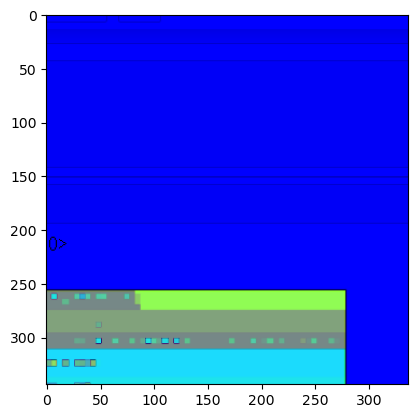

In [166]:
obs = env.get_observation()
done, done_cap = env.get_done()
print(done)
plt.imshow(done_cap)

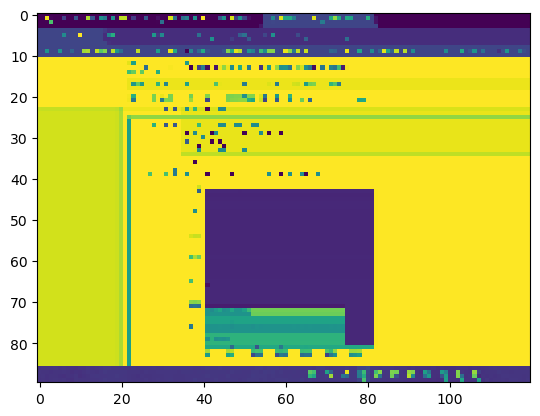

In [167]:
plt.imshow(obs[0])

In [168]:
obs,reward,_,_,_ = env.step(1)
print(reward)

ValueError: invalid literal for int() with base 10: ''

In [142]:
env.reset()
obs,_,_,_,_ = env.step(1)
plt.imshow(cv2.cvtColor(obs[0], cv2.COLOR_GRAY2BGR))

KeyboardInterrupt: 

In [ ]:
obs,_,_,_,_ = env.step(0)
plt.imshow(obs[0])

1187


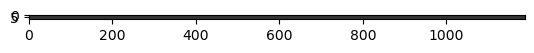

In [15]:
current_health = np.array(env.cap.grab(env.health_location))
plt.imshow(current_health)
c = np.arange(0,1187,1)
cnt = 0
for a in c:
    if current_health[5][a][2] < 200:
        cnt += 1
print(cnt)

# 3. Train the Model

## 3.1 Create Callback

In [179]:
# Import os for file path management
import os
# Import Base Callback for saving models
from stable_baselines3.common.callbacks import BaseCallback
# Check Environment
from stable_baselines3.common import env_checker

In [170]:
env_checker.check_env(env)

ValueError: invalid literal for int() with base 10: ''

In [180]:
class TrainAndLoggingCallback(BaseCallback):
    def __init__(self, check_freq, save_path, verbose=1):
        super(TrainAndLoggingCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.save_path = save_path

    def _init_callback(self):
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self):
        if self.n_calls % self.check_freq == 0:
            model_path = os.path.join(self.save_path, 'best_model_{}'.format(self.n_calls))
            self.model.save(model_path)
            
        return True

In [181]:
CHECKPOINT_DIR = './train/'
LOG_DIR = './logs/'

In [182]:
callback = TrainAndLoggingCallback(check_freq=10000, save_path=CHECKPOINT_DIR)

## 3.2 Build () and Train

In [183]:
from stable_baselines3 import DQN
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.vec_env import DummyVecEnv, VecFrameStack

In [193]:
env = CookieRun()

In [194]:
model = DQN('CnnPolicy', env, tensorboard_log=LOG_DIR, verbose=1, buffer_size=120000, learning_starts=5, learning_rate = 0.01)

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [195]:
model.learn(total_timesteps=500000, callback=callback)

Logging to ./logs/DQN_22


KeyboardInterrupt: 

# 4. Test out Model

In [23]:
model.load('train/best_model_330000') 

In [24]:
for episode in range(5): 
    obs = env.reset()[0]
    total_reward = 0
    done = False
    while not done: 
        action, state = model.predict(obs)
        obs, reward, done, _, info = env.step(int(action))
        total_reward += reward
    print('Total Reward for episode {} is {}'.format(episode, total_reward))

Total Reward for episode 0 is 8770
Total Reward for episode 1 is 7630
Total Reward for episode 2 is 9900


KeyboardInterrupt: 